In [5]:
import csv
import cv2
import numpy as np
import sklearn

samples = []
with open('../simulator_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def generator(samples, batch_size=64):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                
                # create adjusted steering measurements for the side camera images
                correction = 0.5
                steering_left = center_angle + correction
                steering_right = center_angle - correction

                img_left = cv2.imread(batch_sample[1])
                img_right = cv2.imread(batch_sample[2])
                
                images.append(center_image)
                images.append(img_left)
                images.append(img_right)
                angles.append(center_angle)
                angles.append(steering_left)
                angles.append(steering_right)
            
            
            # augment data
            augmented_images, augmented_angles = [], []
            for image, angle in zip(images, angles):
                augmented_images.append(image)
                augmented_angles.append(angle)
                augmented_images.append(cv2.flip(image,1))
                augmented_angles.append(angle*-1.0)

            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)

            yield sklearn.utils.shuffle(X_train, y_train)
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

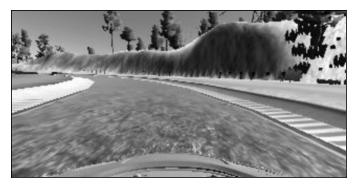

In [10]:
import matplotlib.pyplot as plt

img = cv2.imread(samples[0][0],0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn.utils import shuffle

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5,
        input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((40,20), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,3,3,subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse',optimizer = 'adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=15)      
model.save('model.h5')

Epoch 1/15
3840/3884 [============================>.] - ETA: 1s - loss: 3.4198

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


4032/3884 [===============================] - 138s - loss: 3.2685 - val_loss: 0.1717
Epoch 2/15
3912/3884 [==============================] - 135s - loss: 0.1640 - val_loss: 0.1485
Epoch 3/15
4032/3884 [===============================] - 138s - loss: 0.1367 - val_loss: 0.1308
Epoch 4/15
4032/3884 [===============================] - 139s - loss: 0.1218 - val_loss: 0.1166
Epoch 5/15
4032/3884 [===============================] - 144s - loss: 0.1077 - val_loss: 0.1142
Epoch 6/15
4032/3884 [===============================] - 145s - loss: 0.1019 - val_loss: 0.1013
Epoch 7/15
4032/3884 [===============================] - 147s - loss: 0.0994 - val_loss: 0.1055
Epoch 8/15
3912/3884 [==============================] - 140s - loss: 0.0928 - val_loss: 0.0886
Epoch 9/15
4032/3884 [===============================] - 148s - loss: 0.0896 - val_loss: 0.0921
Epoch 10/15
4032/3884 [===============================] - 142s - loss: 0.0933 - val_loss: 0.0826
Epoch 11/15
4032/3884 [=============================

dict_keys(['loss', 'val_loss'])


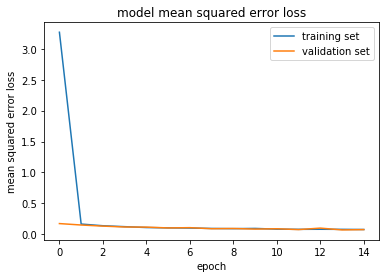

In [21]:
import matplotlib.pyplot as plt
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('plots/model_mse.png',bbox_inches='tight')
plt.show()

In [8]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5,
        input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((40,20), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,3,3,subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse',optimizer = 'adam')

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 160, 320, 3)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
cropping2d_3 (Cropping2D)        (None, 100, 320, 3)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 48, 158, 24)   1824        cropping2d_3[0][0]               
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 22, 77, 36)    21636       convolution2d_9[0][0]            
___________________________________________________________________________________________

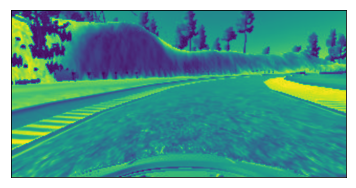

In [32]:
import matplotlib.pyplot as plt

img = cv2.imread('plots/center_2018_04_16_13_29_12_036.jpg',0)
img = cv2.flip(img,1)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.imshow(img, interpolation = 'bicubic')
plt.savefig('plots/flipped_img.png',bbox_inches='tight')
plt.show()